In [117]:
# TO DO LIST:

# useful visualizations:

# > Original Image
# > Original Resized Image

# > Predicted Image
# > Predicted Image resized to the size of the original

# ... basically just two plots:
# ... def assess_singular_run(metric: list) -> for 1 run
# ... def assess_various_runs(metrics: list[list]) -> for avg run
# ... also need a 'for loop' to be able to compare different runs

# > For 1 run: fitness history over generations
# > For n runs (when doing grid search): average run
# > For 1 run: Phenotypic entropy history over generations
# > For n runs (when doing grid search): average run
# > For 1 run: Phenotypic variance history over generations
# > For n runs (when doing grid search): average run
# NOTE: we can also use the median (more resistant to outliers)

# > comparison against computational effort (e.g. when # of gens. differ)
# ... to draw the curves of the ABF, instead of plotting the first column against
# the second, we simply plot the third column against the second. In other words, we
# report the cumulative number of fitness evaluations on the horizontal axis, and the
# ABF on the vertical axis.

In [15]:
import os
import ast
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

- **Load Data**

In [2]:
def load_pickle(filename):
    return pd.read_pickle(filename)

In [3]:
# tests
best_indivs = load_pickle('grid/selec_alg/selec_alg_best_individual_list.pkl')
best_params = load_pickle('grid/selec_alg/selec_alg_best_param.pkl')

print(len(best_indivs))
print(len(best_indivs[0]), len(best_indivs[1]))
print(best_params)

# ... i.e. len(best_indivs) = GA configurations tested
# ... i.e. len(best_indivs[i]) = number of generations
# ... i.e. best_params = idx of best configuration? TODO check if True

# TODO need to add population size for the computational efforts plots

2
1000 1000
1


In [4]:
best_indivs = load_pickle('grid/pop_size_3/pop_size_3_best_individual_list.pkl')
best_params = load_pickle('grid/pop_size_3/pop_size_3_best_param.pkl')

print(len(best_indivs))
print(len(best_indivs[0]), len(best_indivs[1]), len(best_indivs[3]), '...')
print(best_params)

# ... i.e. more than 2 GA configurations might have been performed...

24
200 200 200 ...
18


In [113]:
for i, indiv in enumerate(best_indivs):
    print(f'{i+1}: {len(indiv)}')

1: 200
2: 200
3: 200
4: 200
5: 200
6: 200
7: 200
8: 200
9: 200
10: 200
11: 200
12: 200
13: 200
14: 200
15: 200
16: 200
17: 200
18: 200
19: 200
20: 200
21: 200
22: 200
23: 200
24: 200


- **Plotting Images**

In [5]:
# plot image

def plot_image(image, title='Image', size=None):
    if isinstance(image, str):
        image = Image.open(image)
    elif isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    else:
        raise ValueError('Image must be a string file path or a numpy array')
    
    if size:
        image = image.resize(size)
    
    plt.imshow(image, cmap='gray')
    plt.title(f'{title} ({image.size[0]}x{image.size[1]})')
    plt.show()

In [ ]:
# tests
# > original img
# > original img resized
# > example best image from run
# > example best image from run but resized to size of the original image

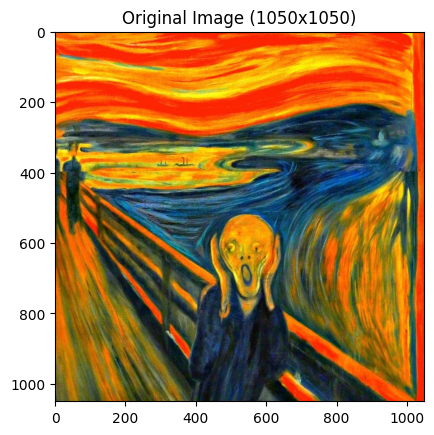

In [6]:
# original image
plot_image('scream.jpg', 'Original Image')

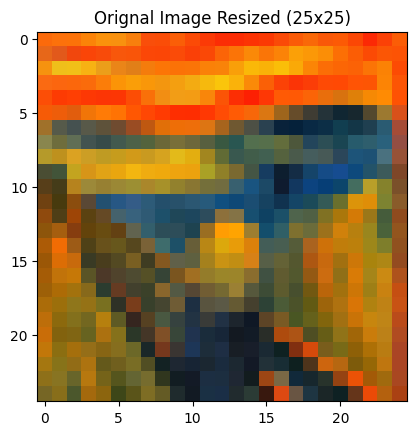

In [7]:
# originl image resized
plot_image('scream.jpg', 'Orignal Image Resized', size=(25, 25))

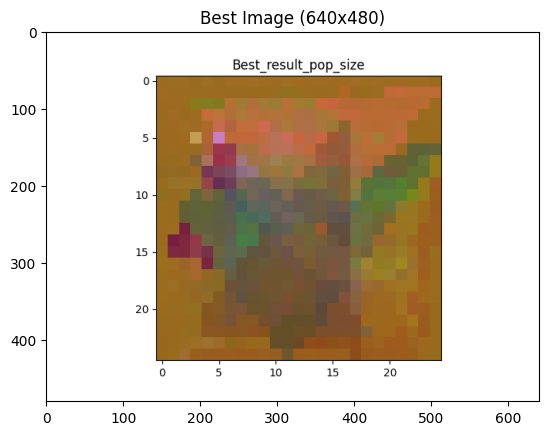

In [8]:
# example best image from run
plot_image('grid/pop_size_3/best_individual_pop_size.png', 'Best Image')

# ... ahah, need the real array

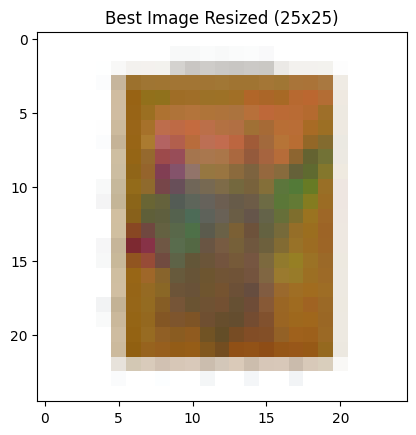

In [9]:
# example best image from run but resized to size of the original image
plot_image('grid/pop_size_3/best_individual_pop_size.png', 'Best Image Resized', size=(25, 25))

- **For 1 Run**

In [10]:
def compare_trials(*trials):
    gens = range(len(trials[0]))  # assuming all trials have the same number of generations
    for i, trial in enumerate(trials):
        plt.plot(gens, trial, label=f'Trial {i+1}')
    plt.title('Fitness History')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()
    plt.show()

In [99]:
len(best_indivs)  # number of GA configurations tested

24

In [79]:
len(best_indivs[0])  # number generations per trial

# i.e. best_indivs[i] = list of trials for GA configuration i

200

In [93]:
len(best_indivs[0][0]) # number of generations per trial

# i.e. best_indivs[i][j] = list of best individual in trial j of configuration i

200

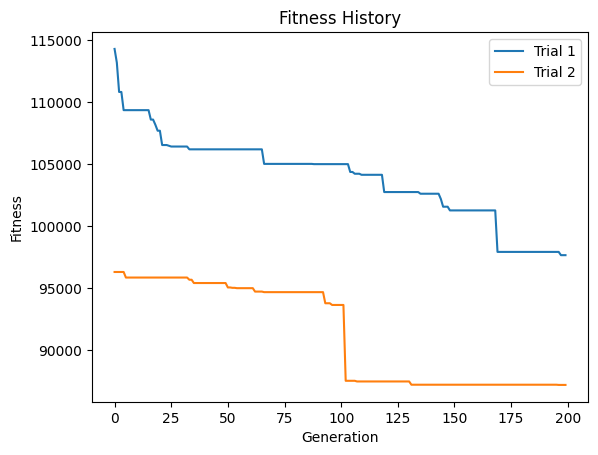

In [11]:
# tests
compare_trials([best_indivs[17][i][0] for i in range(200)], [best_indivs[17][i][1] for i in range(200)])

- **For n Runs (ABF or MBF - avg. or median)**

In [31]:
def compare_configs(metric, parameter, *configs, title='Fitness History', error_bar_step=20, figsize=(6, 4)):
    
    plt.figure(figsize=figsize)
        
    for i, config in enumerate(configs):
        if metric == 'mean':
            y = np.mean(config, axis=1)
            yerr = np.std(config, axis=1)
        elif metric == 'median':
            y = np.median(config, axis=1)
        else:
            raise ValueError('Invalid metric. Accepted are "mean" and "median".')
# 
        x = range(len(y))
        
        # Plot the main line
        line, = plt.plot(x, y, label=f'Configuration {i+1}', )
        color = line.get_color()
        
        # Adding error bars (mean only)
        if (error_bar_step > 0) & (metric != 'median'):        
            # Plot error bars at intervals
            error_x = x[::error_bar_step]
            error_y = y[::error_bar_step]
            error_yerr = yerr[::error_bar_step]
            plt.errorbar(error_x, error_y, yerr=error_yerr, fmt='o', capsize=5, color=color)

    plt.title(title)
    plt.xlabel('Generation')
    plt.ylabel(f'{metric.capitalize()} {parameter}')
    plt.legend()
    plt.show()

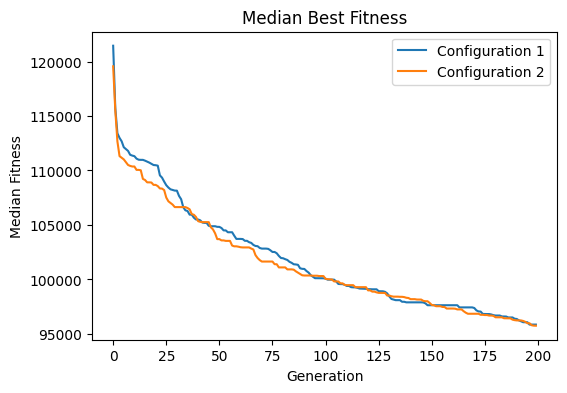

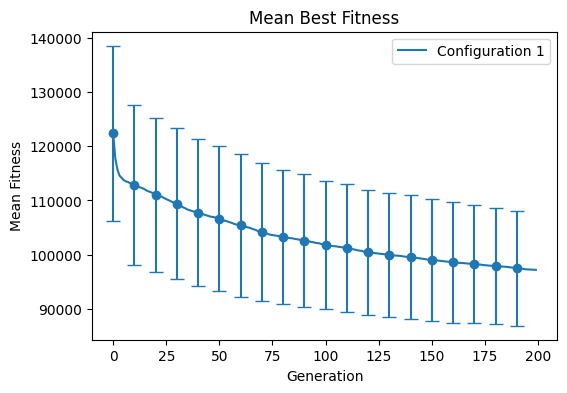

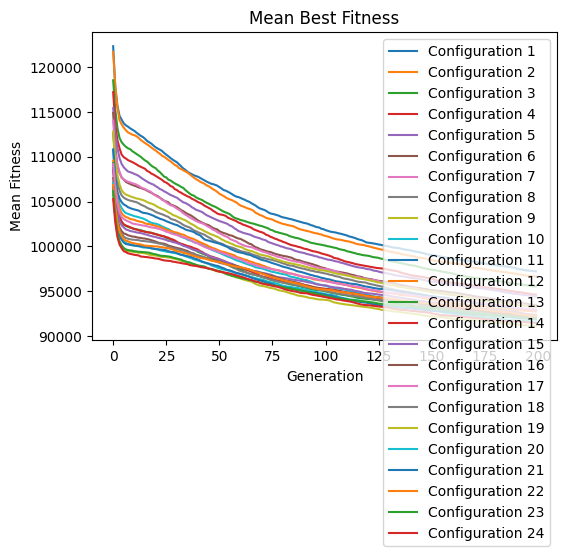

In [34]:
# tests:
# 1. 2 configs
# 2. one config
# 3. all configs

compare_configs('median', 'Fitness', best_indivs[0], best_indivs[1], error_bar_step=0, title='Median Best Fitness')
compare_configs('mean', 'Fitness', best_indivs[0], error_bar_step=10, title='Mean Best Fitness')
compare_configs('mean', 'Fitness', *tuple(best_indivs), error_bar_step=0, title='Mean Best Fitness')  # obviously looks terrible but it works

# ... everything working as intended

In [ ]:
# other tests

# basically here we should change the parameter to be the phenotypic entropy or variance

# mean entropy
compare_configs()

# median entropy
compare_configs()

# mean variance
compare_configs()

# median variance
compare_configs()

- **Comparison against computation effort**

In [42]:
def read_txt(filename):
    # reads the pop size from txt file
    # we will only use this function for grid searches aimed at finding the best pop size
    with open(filename, 'r') as f:
        for current_line_number, line in enumerate(f, start=1):
            # since struc. does not change the params. we are interested
            # in are always in the same line, i.e. line 3
            if current_line_number == 3:  
                lst = line.split(': ')[-1].strip()
                return ast.literal_eval(lst)
            

def get_pop_size(filename, *config_idx):
    pop_sizes = read_txt(filename)
    return [pop_size for i, pop_size in enumerate(pop_sizes) if i in config_idx]
    
        

# test
print(f'Pop. size of config. 0: {get_pop_size('grid/pop_size_3/pop_size_3.txt', 0)}')
print(f'Pop. size of configs. 0, 1 and 2, respectively: {get_pop_size('grid/pop_size_3/pop_size_3.txt', 0, 1, 2)}')

Pop. size of config. 0: [7]
Pop. size of configs. 0, 1 and 2, respectively: [7, 8, 9]


In [80]:
def compare_effort(pop_sizes, configs, metric='mean', title='Computational Effort', figsize=(6, 4)):
    plt.figure(figsize=figsize)
    
    for i, config in enumerate(configs):
        x = pop_sizes[i] * np.arange(1, len(config)+1)
        y = np.mean(config, axis=1)
        plt.plot(x, y, label=f'Configuration {i+1}: Pop. Size {pop_sizes[i]}')
    
    plt.title(title)
    plt.xlabel('# Fit. Eval.')
    plt.ylabel(f"{'Average' if metric=='mean' else 'Median'} Best Fitness")
    plt.legend()
    plt.show()

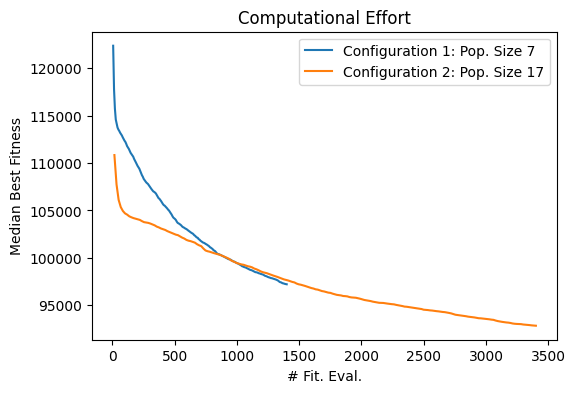

In [81]:
# tests
compare_effort(
    get_pop_size('grid/pop_size_3/pop_size_3.txt', 0, 10),
    [best_indivs[0], best_indivs[10]],
    metric='median'
)